# Visualizing cartographic variables to inform feature selection for predicting forest cover type

Original data and description can be found at: https://archive.ics.uci.edu/ml/datasets/Covertype

# Import packages

In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Local functions 

In [28]:
def reverse_dummy(df, col_name, col_list):
    '''
    Takes a df, a column name and a list of dummy variable column names as arguments.
    Combines dummy variables into a single column and drops dummy variable columns.
    Returns df.
    '''
    df[col_name] = ''
    for i in col_list:
        df[col_name] = np.where(df[i] == 1, i, df[col_name])
    df = df.drop(col_list, axis = 1)
    
    #convert strings to numeric
    num_list = list(range(1, len(col_list) + 1))
    for num in num_list:
        df[col_name] = df[col_name].replace((col_name + str(num)), num)
    return df

def get_subset(df, stratify_by = 'cover_type', test_size = 1/50):
    '''
    Stratified sampling of original df for plotting.
    Default stratify_by = cover_type and test_size = 1/50.
    Returns new downsampled df.
    '''
    y = df[stratify_by]
    X = df
    _, _, _, to_plot = train_test_split(X, y , stratify = y)
    df_subset = df[df.index.isin(to_plot.index)]
    return df_subset

def plot_violin(y, data, x = 'cover_type', scale = 'count'):
    '''
    Creates a violinplot of y vs. x (default cover_type)
    '''
    return sns.violinplot(x = x, y = y, data = data, palette = 'Set2',
                          scale = scale, inner = 'quartile', scale_hue = False)

# Load raw data 

In [5]:
raw_file = pd.read_csv('covtype.data.gz', compression = 'gzip', header = None)

In [6]:
pd.set_option('display.max_columns', 100)
raw_file.head()

0    1   2    3    4     5    6    7    8     9   10  11  12  13  14  15  \
0  2596   51   3  258    0   510  221  232  148  6279   1   0   0   0   0   0   
1  2590   56   2  212   -6   390  220  235  151  6225   1   0   0   0   0   0   
2  2804  139   9  268   65  3180  234  238  135  6121   1   0   0   0   0   0   
3  2785  155  18  242  118  3090  238  238  122  6211   1   0   0   0   0   0   
4  2595   45   2  153   -1   391  220  234  150  6172   1   0   0   0   0   0   

   16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  \
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

   35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  \
0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   

   54  
0   5  
1   5  
2   2  
3   2  
4   5

The column names are missing in the raw file. Kaggle provides a smaller data set ('train.csv') with the column names at https://www.kaggle.com/c/forest-cover-type-prediction/data

In [8]:
#get column names from 'train.csv'
cols_file = pd.read_csv('train.csv.zip', compression = 'zip')
cols_file.columns

Index([u'Id', u'Elevation', u'Aspect', u'Slope',
       u'Horizontal_Distance_To_Hydrology', u'Vertical_Distance_To_Hydrology',
       u'Horizontal_Distance_To_Roadways', u'Hillshade_9am', u'Hillshade_Noon',
       u'Hillshade_3pm', u'Horizontal_Distance_To_Fire_Points',
       u'Wilderness_Area1', u'Wilderness_Area2', u'Wilderness_Area3',
       u'Wilderness_Area4', u'Soil_Type1', u'Soil_Type2', u'Soil_Type3',
       u'Soil_Type4', u'Soil_Type5', u'Soil_Type6', u'Soil_Type7',
       u'Soil_Type8', u'Soil_Type9', u'Soil_Type10', u'Soil_Type11',
       u'Soil_Type12', u'Soil_Type13', u'Soil_Type14', u'Soil_Type15',
       u'Soil_Type16', u'Soil_Type17', u'Soil_Type18', u'Soil_Type19',
       u'Soil_Type20', u'Soil_Type21', u'Soil_Type22', u'Soil_Type23',
       u'Soil_Type24', u'Soil_Type25', u'Soil_Type26', u'Soil_Type27',
       u'Soil_Type28', u'Soil_Type29', u'Soil_Type30', u'Soil_Type31',
       u'Soil_Type32', u'Soil_Type33', u'Soil_Type34', u'Soil_Type35',
       u'Soil_Type36', 

train.csv has an extra column ('Id') that is not in the raw file provided by UCI. Drop 'Id' column and coerce column names to lowercase. Rename columns in raw_file and check for null values

In [9]:
cols_file = cols_file.drop('Id', axis = 1)
col_names = cols_file.columns.str.lower()
raw_file.columns = col_names
raw_file.head()
raw_file.isnull().values.any()

elevation  aspect  slope  horizontal_distance_to_hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   vertical_distance_to_hydrology  horizontal_distance_to_roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   hillshade_9am  hillshade_noon  hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   
3            238             238            122   
4            220             234            150   

   horizontal_distance_to_fire_points  wilderness_area1  wilderness_area2  \
0                                6279                 1                 0   
1                                6225                 1                 0   
2                                6121                 1                 0   
3                                6211                 1                 0   
4                                6172                 1                 0   

   wilderness_area3  wilderness_area4  soil_type1  soil_type2  soil_type3  \
0                 0                 0           0           0           0   
1                 0                 0           0           0           0   
2                 0                 0           0           0           0   
3                 0                 0           0           0           0   
4                 0                 0           0           0           0   

   soil_type4  soil_type5  soil_type6  soil_type7  soil_type8  soil_type9  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   soil_type10  soil_type11  soil_type12  soil_type13  soil_type14  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            1            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   soil_type15  soil_type16  soil_type17  soil_type18  soil_type19  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   soil_type20  soil_type21  soil_type22  soil_type23  soil_type24  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   soil_type25  soil_type26  soil_type27  soil_type28  soil_type29  \
0            0            0            0            0            1   
1            0            0            0            0            1   
2            0        

False

There are two categorical variables (wilderness_area and soil_type) that are already one-hot-encoded. To perform exploratory data visualization it will be easier to reverse the one-hot-encoding.

In [22]:
#create lists of dummy variable column names
wild_area = list(raw_file.columns[10:14])
soil_type = list(raw_file.columns[14:54])

#make copy to keep raw_file, will need dummy variables later
features = raw_file.copy()
features = reverse_dummy(features, 'wilderness_area', wild_area)
features = reverse_dummy(features, 'soil_type', soil_type)

#shorten names
short_names = ['elevation aspect slope h_dist_hydro v_dist_hydro dist_road shade_9 shade_12 shade_3 dist_fire cover_type area soil'.split()]
features.columns = short_names
features.head()

elevation  aspect  slope  h_dist_hydro  v_dist_hydro  dist_road  shade_9  \
0       2596      51      3           258             0        510      221   
1       2590      56      2           212            -6        390      220   
2       2804     139      9           268            65       3180      234   
3       2785     155     18           242           118       3090      238   
4       2595      45      2           153            -1        391      220   

   shade_12  shade_3  dist_fire  cover_type  area  soil  
0       232      148       6279           5     1    29  
1       235      151       6225           5     1    29  
2       238      135       6121           2     1    12  
3       238      122       6211           2     1    30  
4       234      150       6172           5     1    29

# Exploratory data visualization

Our goal is to visualize the forest cover data to try and identify features that will be important for creating a model that predicts forest cover type. First, let's examine the class distributions of our ouputs, cover_type.

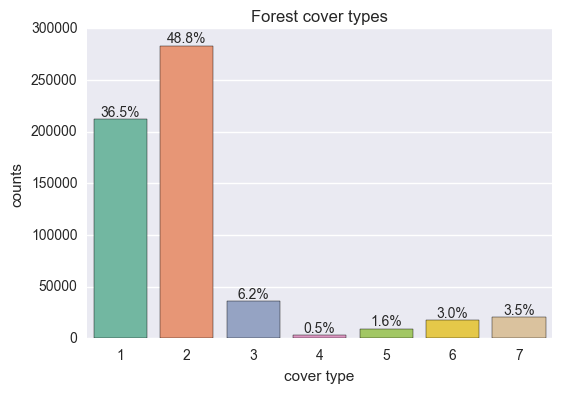

In [23]:
counts = pd.DataFrame()
counts['raw'] = features['cover_type'].value_counts()
counts['percent'] = counts['raw'] / features['cover_type'].count()
counts['cover_type'] = counts.index.values
p = sns.barplot(x = 'cover_type', y = 'raw', data = counts, palette = 'Set2');
_ = p.set(xlabel = 'cover type', ylabel = 'counts', title = 'Forest cover types');

total = len(features)
for patch in p.patches:
    height = patch.get_height()
    _ = p.annotate('{:.1f}%'.format(100.*height/total), (patch.get_x() + 0.4, height), fontsize = 10,
            ha = 'center', va = 'bottom');

There is a very clear imbalance between the seven classes. This will need to be taken into account when we build our model for predictions. Furthermore, there are too many samples in the data set to visualize easily. We will thus select a subset of our data in a stratified manner to preserve the relative percentages of cover types for visualizations. During model training, oversampling of the less represented classes should be considered.

In [25]:
features

elevation  aspect  slope  h_dist_hydro  v_dist_hydro  dist_road  \
0            2596      51      3           258             0        510   
1            2590      56      2           212            -6        390   
2            2804     139      9           268            65       3180   
3            2785     155     18           242           118       3090   
4            2595      45      2           153            -1        391   
5            2579     132      6           300           -15         67   
6            2606      45      7           270             5        633   
7            2605      49      4           234             7        573   
8            2617      45      9           240            56        666   
9            2612      59     10           247            11        636   
10           2612     201      4           180            51        735   
11           2886     151     11           371            26       5253   
12           2742     134     22           150            69       3215   
13           2609     214      7           150            46        771   
14           2503     157      4            67             4        674   
15           2495      51      7            42             2        752   
16           2610     259      1           120            -1        607   
17           2517      72      7            85             6        595   
18           2504       0      4            95             5        691   
19           2503      38      5            85            10        741   
20           2501      71      9            60             8        767   
21           2880     209     17           216            30       4986   
22           2768     114     23           192            82       3339   
23           2511      54      8           124             0        638   
24           2507      22      9           120            14        732   
25           2492     135      6             0             0        860   
26           2489     163     10            30            -4        849   
27           2962     148     16           323            23       5916   
28           2811     135      1           212            30       3670   
29           2739     117     24           127            53       3281   
...           ...     ...    ...           ...           ...        ...   
580982       2431     182      9           300            23        268   
580983       2436     219     15           300            28        256   
580984       2441     201     15           300            33        247   
580985       2442     191     17           300            34        242   
580986       2444     202     21           300            37        240   
580987       2450     203     27           300            53        240   
580988       2455     189     31           295            58        240   
580989       2455     181     34           277            58        240   
580990       2455     166     35           258            58        240   
580991       2445     157     33           242            49        240   
580992       2441     173     28           228            45        242   
580993       2440     173     26           216            44        234   
580994       2437     170     23           201            45        216   
580995       2437     174     22           190            45        201   
580996       2435     171     22           175            43        190   
580997       2433     168     23           162            41        175   
580998       2429     166     24           153            45        162   
580999       2426     168     24           150            42        153   
581000       2423     169     24           134            39        150   
581001       2421     172     25           124            35        134   
581002       2419     168     25           108            33        124   
581003       2415     161     25 

In [29]:
features_plot = get_subset(features)
features.shape
features_plot.shape

(581012, 13)

(145253, 13)

## All comparisons 

We have a total of 12 features, which is still small enough that pairwise comparisons will allow us to see some basic patterns/correlations within the data.

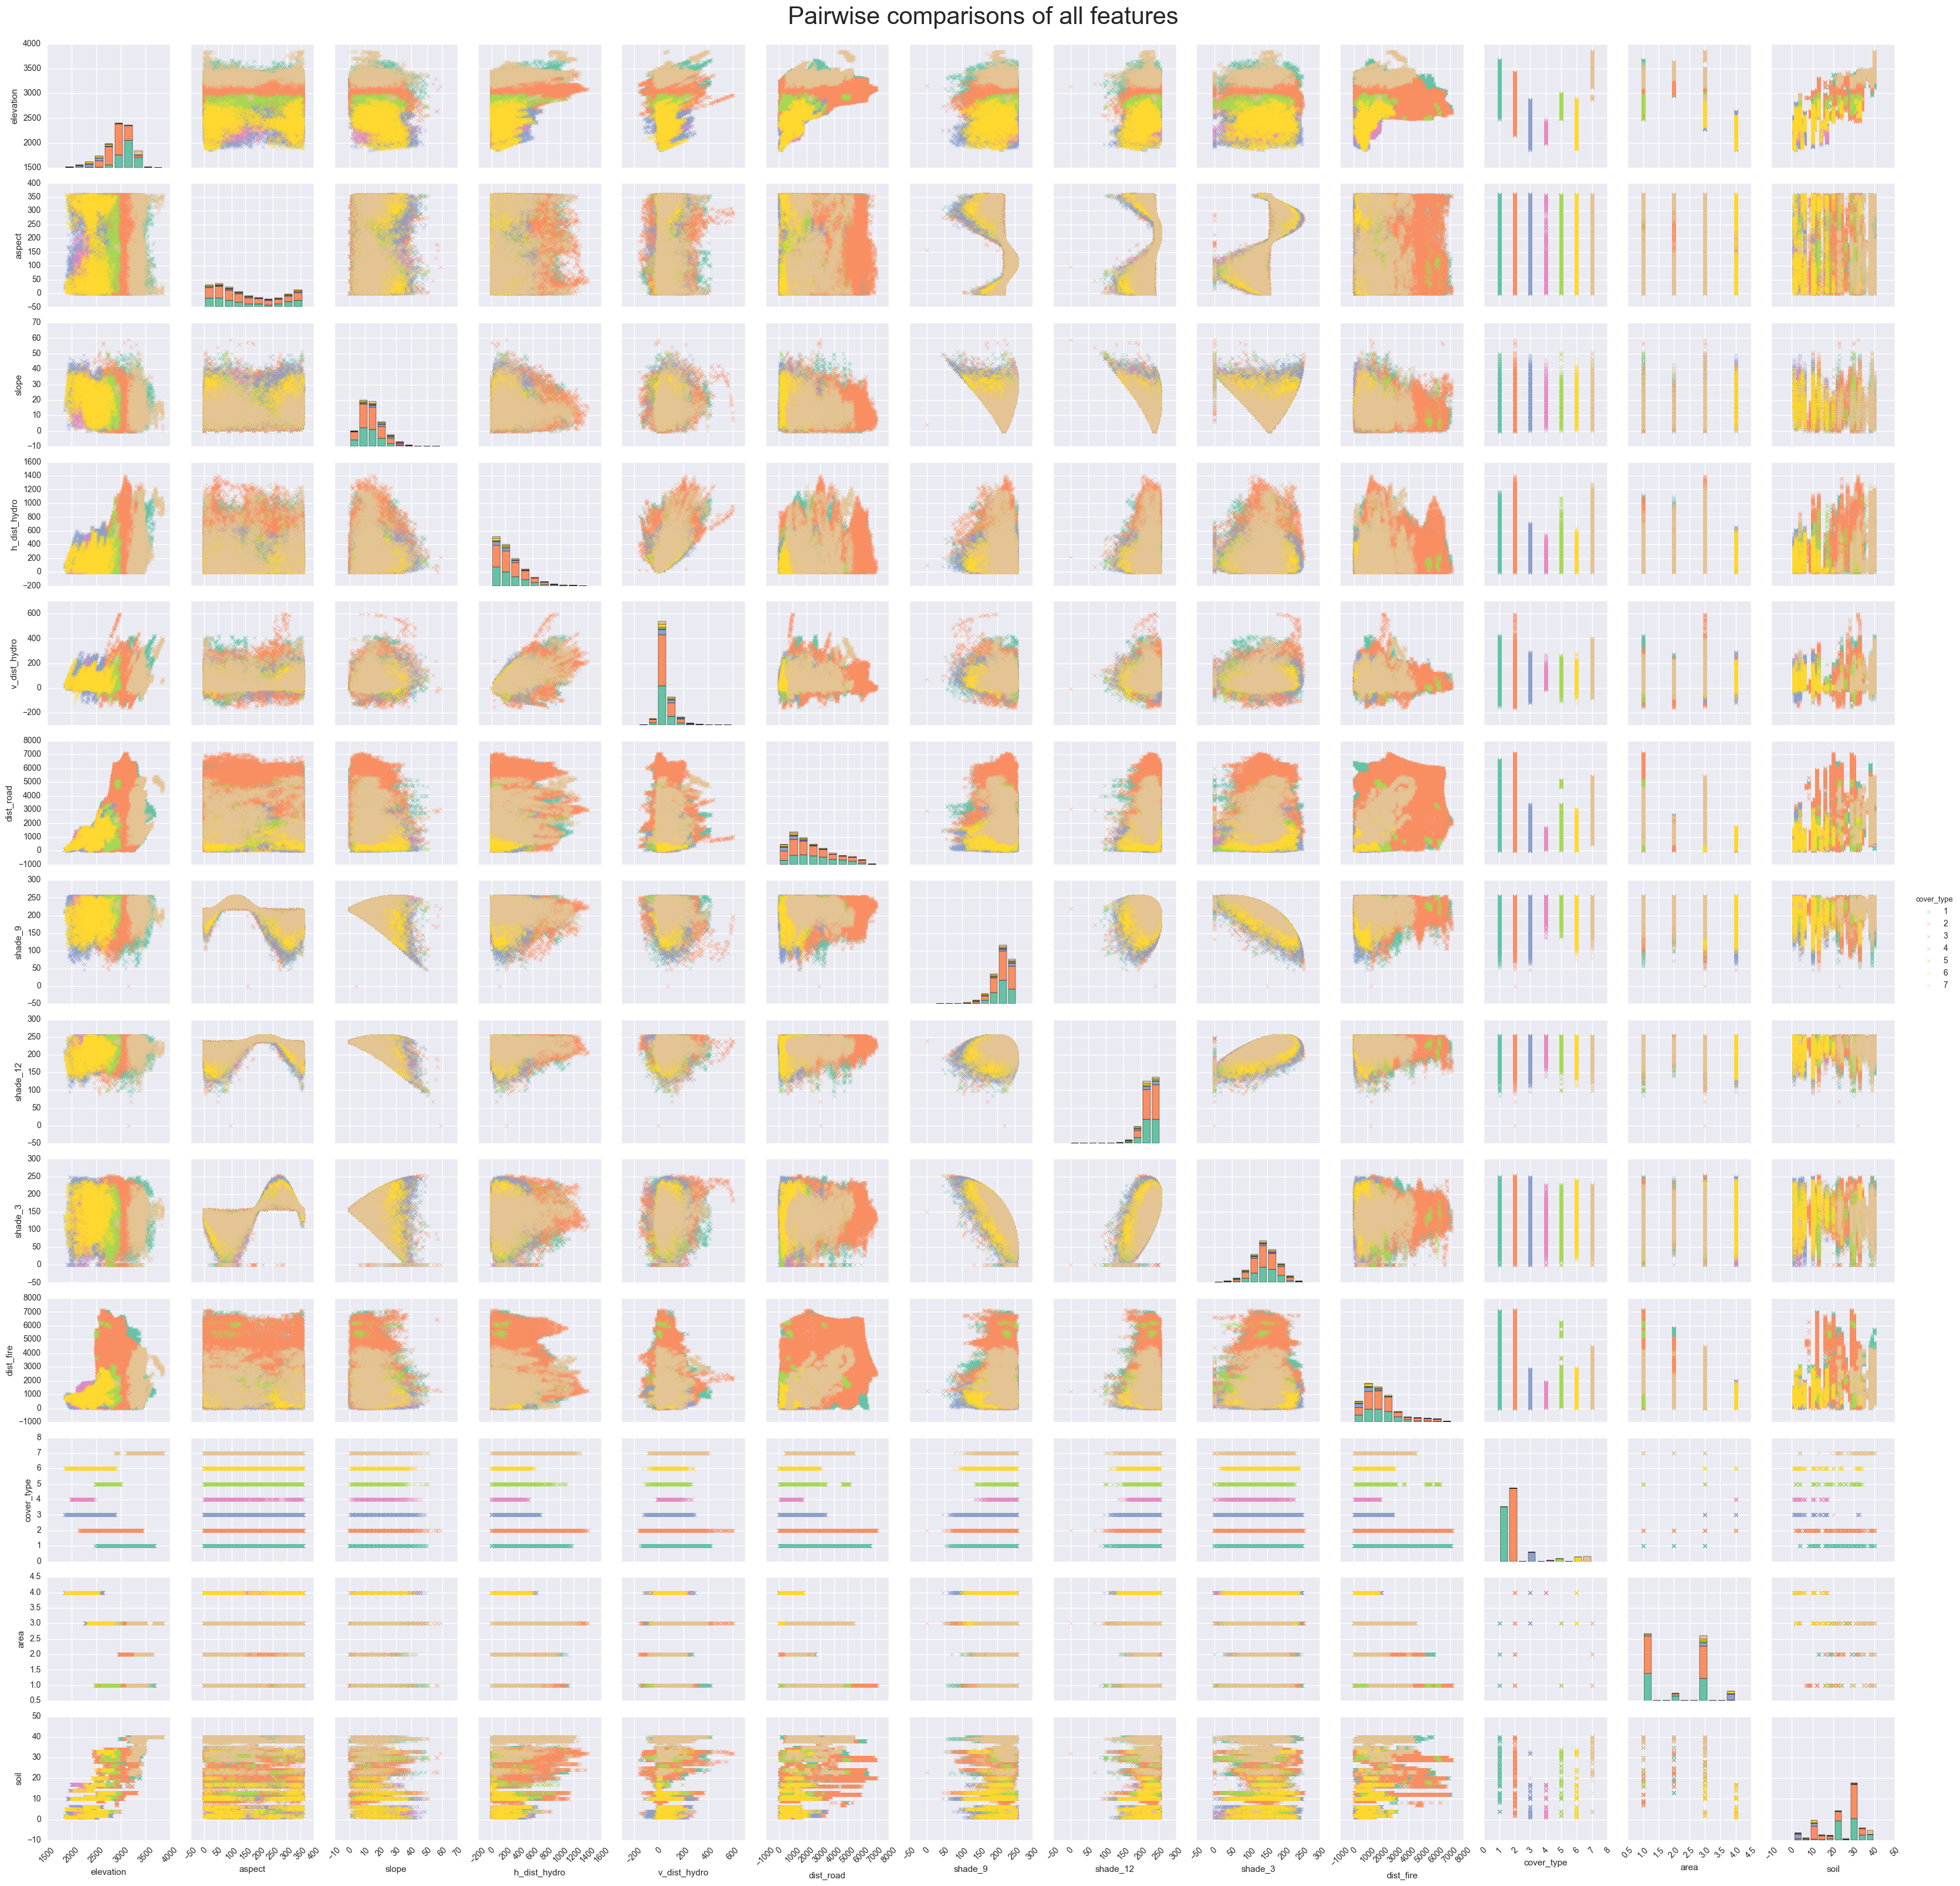

In [30]:
f = sns.pairplot(features_plot, hue = 'cover_type', markers = 'x', palette = 'Set2')
_ = f.fig.suptitle('Pairwise comparisons of all features', verticalalignment = 'top', fontsize = 30);
f.fig.subplots_adjust(top = 0.96);
for ax in f.axes.flat:
    _ = plt.setp(ax.get_xticklabels(), rotation=45);

Outputting the file allows more in-depth exploration of figure f compared to viewing in the notebook.

In [ ]:
f.savefig('pairplot.png')

From figure f we note several things:
* Several features are correlated; however, many correlations are not simple linear ones, therefore Pearson's correlation will not capture the relationship between these variables. Furthermore, the non-linear relationships look spherical or periodic, consistent with angle measurements.
* Even though we don't have many featuers, dimensionality reduction could still aid in visualizing/identifying important features for classifications.
* Most of the quantitative features seem to be evenly distributed across the seven cover types.
* Elevation (top row) is the only feature where some clustering by cover type can be discerned.

## Plotting individual comparisons 

As elevation seemed to cluster data by cover type, let's plot elevation vs. cover type individually.

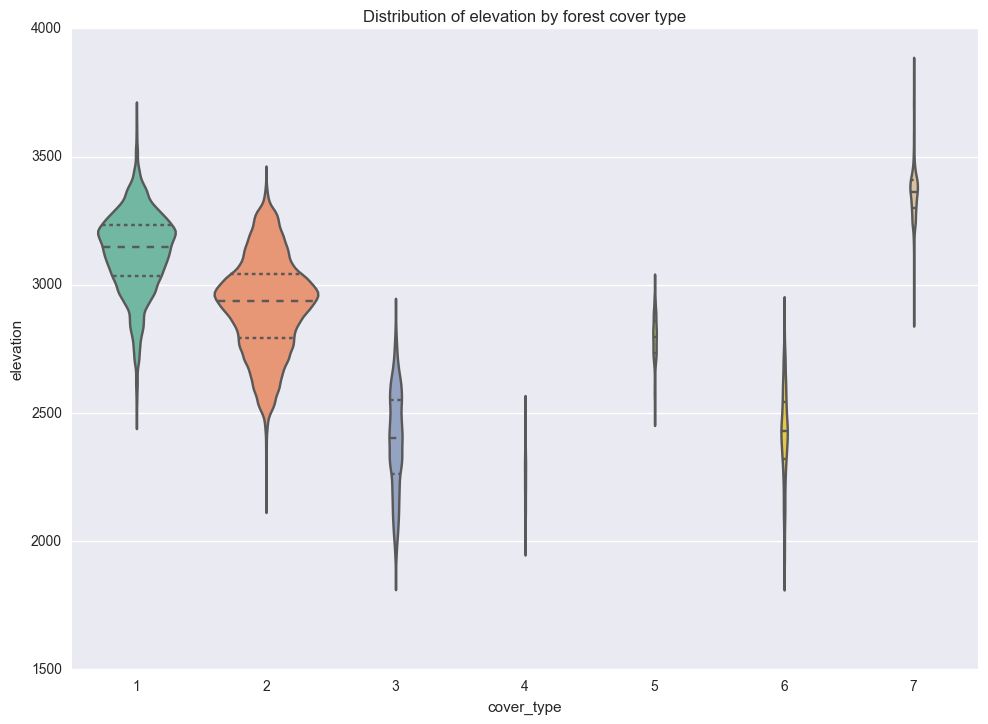

In [78]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27);
g1 = plot_violin('elevation', data = features, scale = 'count');
g1.set(title = 'Distribution of elevation by forest cover type');

Elevation achieves some separation between the cover types and will thus serve as a good predictor. Note the area of the violin plots are scaled by the number of samples per cover type.

Additionally, the pairplot cannot capture the relationship of cover types and the two categorical variables. Let's plot these separately.

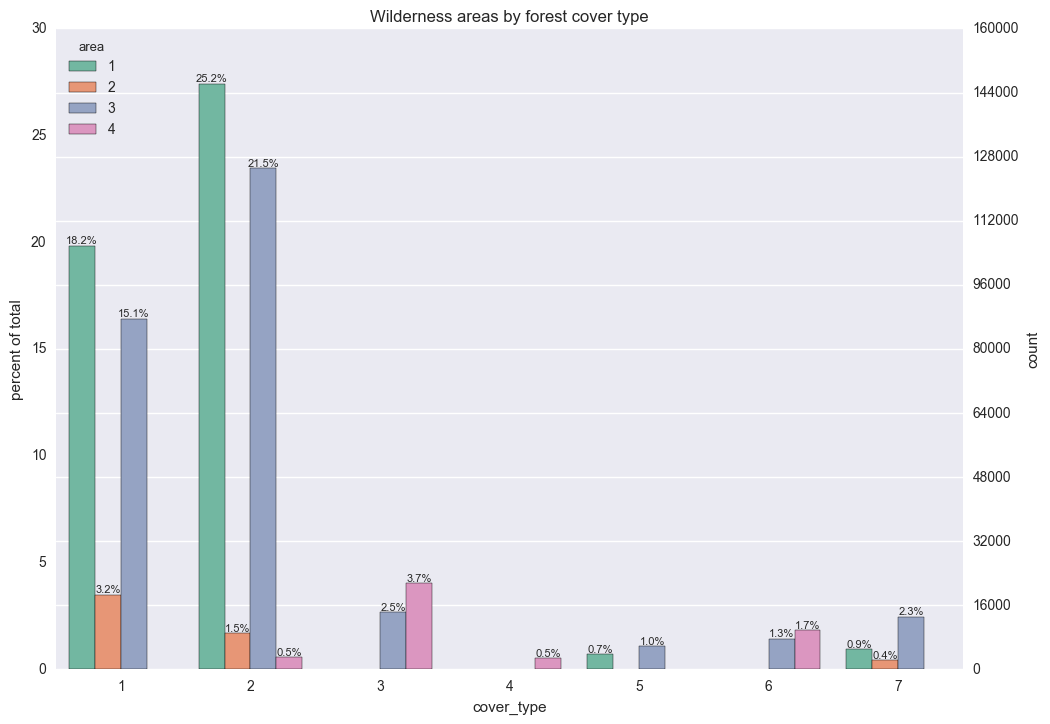

In [106]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27);
g = sns.countplot(x = 'cover_type', hue = 'area', data = features, palette = 'Set2')
_ = g.set(title = 'Wilderness areas by forest cover type');

# Make twin axis
h = g.twinx()

# Switch so count axis is on right, frequency on left
h.yaxis.tick_left()
g.yaxis.tick_right()

# Also switch the labels over
g.yaxis.set_label_position('right')
h.yaxis.set_label_position('left')

_ = h.set_ylabel('percent of total')

total = len(features)
for p in g.patches:
    x = p.get_bbox().get_points()[:,0];
    y = p.get_bbox().get_points()[1,1];
    _ = g.annotate('{:.1f}%'.format(100.*y/total), (x.mean(), y), fontsize = 8,
            ha = 'center', va = 'bottom'); # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
_ = g.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range
_ = h.set_ylim(0, 30);
#g.set_ylim(0, ncount/2);

# And use a MultipleLocator to ensure a tick spacing of 10
h.yaxis.set_major_locator(ticker.MultipleLocator(5))

# Need to turn the grid on h off, otherwise the gridlines end up on top of the bars
h.grid(None)

We may be able to separate cover types 1 and 2 from 3 through 7 by wilderness area, but any further splits on wilderness area alone are not possible. 

Although soil type is also a categorical variable, 40 subcategories are difficult to visualize with a bar plot. Therefore let's plot the individual soil type values by cover type. We'll overlay violin plots to help visualize the distribution of soil types.

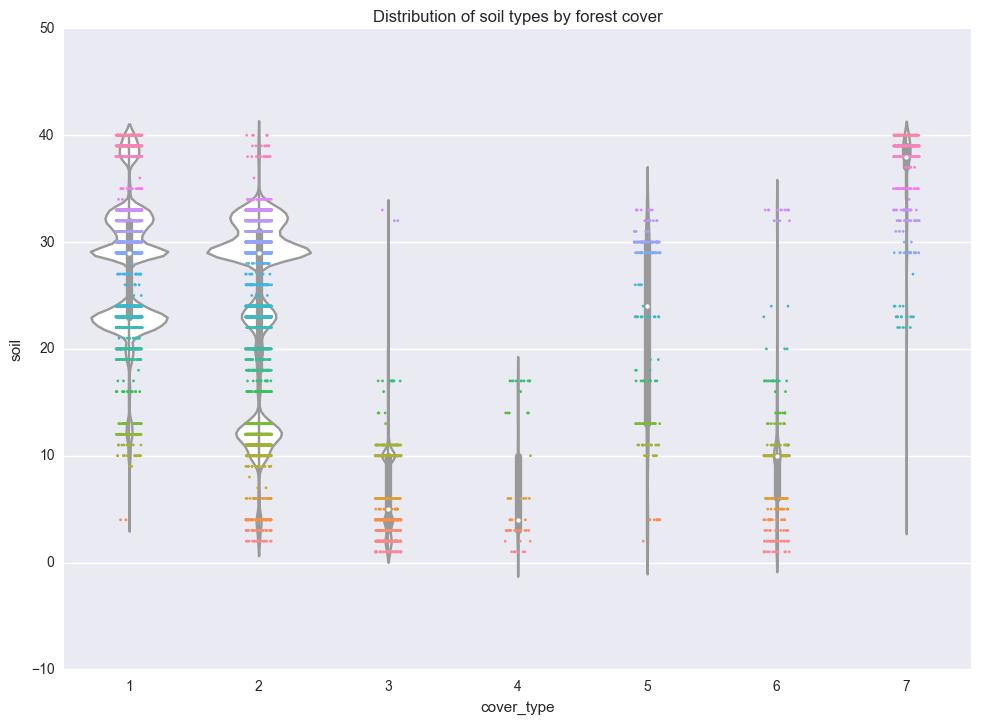

In [87]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27);
g3 = sns.stripplot(x = 'cover_type', y = 'soil', hue = 'soil', data = features_plot, 
                   jitter = True, size = 2);
sns.violinplot(x = 'cover_type', y = 'soil', data = features, scale = 'count', color = 'white');
g3.set(title = 'Distribution of soil types by forest cover');
g3.legend_.remove();

Soil type may allow us to split cover types into smaller subgroups.

Let's plot elevation, soil type and cover type together.

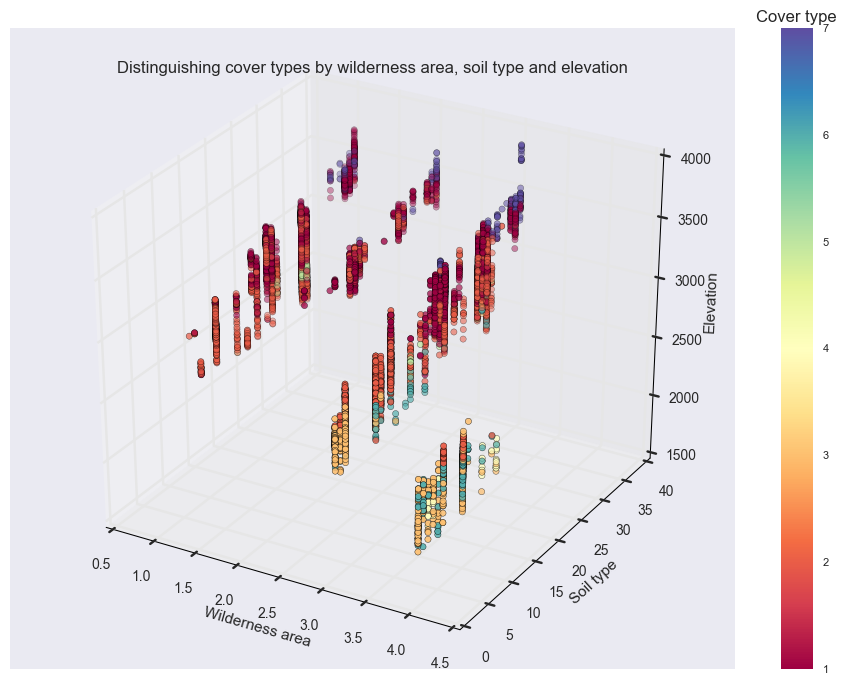

In [151]:
#set up 3D figure
fig = plt.figure()
fig.set_size_inches(11.7, 8.27);
ax = fig.add_subplot(111, projection='3d')

#make scatterplot
p = ax.scatter(xs = features_plot['area'], ys = features_plot['soil'], zs = features_plot['elevation'],
                  c = features_plot['cover_type'], cmap=plt.cm.Spectral);

#set axes
_ = ax.dist = 10
_ = ax.set_ylim(0, 40)

#add and format colorbar
cbar = fig.colorbar(p);
cbar.set_ticks([1, 2, 3, 4, 5, 6, 7]);
cbar.set_ticklabels([1, 2, 3, 4, 5, 6, 7]);
cbar.ax.tick_params(labelsize = 8); 

#add labels
_ = cbar.ax.set_title('Cover type')
_ = ax.set_title('Distinguishing cover types by wilderness area, soil type and elevation')
_ = ax.set_xlabel('Wilderness area')
_ = ax.set_ylabel('Soil type')
_ = ax.set_zlabel('Elevation')

This plot suggests classification of forest cover type by these three features may be a good place to start; however, there is still a lot of overlap between the different cover types, particularly between cover types 1 and 2. We also haven't explored the other features at all.

# Dimensionality reduction 

Although this data set only has 12 features, it is still difficult to visualize the interactions of all the features and identify those that will be important for predicting forest cover type. Although we've identified three features (see 3D plot above) that may be a good starting point for our model, we want to know if we can reduce the overlap even further. Therefore, dimensionality reduction may still aid visualization and feature selection.

## Data processing 

We subsample our full data set and standardize the resulting data so that we can run our dimensionality reduction techniques. Using the full data set would be ideal, but the computational complexity is a problem for personal computers.

In [41]:
data_subset = get_subset(raw_file)

Features need to be standardized for dimensionality reduction; one-hot-encoded variables don't need to be scaled

In [96]:
features_to_scale = data_subset.iloc[:, 0:10]
scaled_features = (features_to_scale - features_to_scale.mean()) / features_to_scale.std()

#merge dfs of standardized and dummy features back together
df_reduction = pd.concat([scaled_features, data_subset.iloc[:, 10:-1]], axis = 1)
df_reduction.head()

elevation    aspect     slope  horizontal_distance_to_hydrology  \
2    -0.563944 -0.155440 -0.691223                         -0.010610   
3    -0.632094 -0.012956  0.516460                         -0.131723   
175  -0.033093 -1.322028 -0.959597                          1.014195   
316  -1.051753 -1.028155  0.382273                          0.059263   
328   1.060890  1.598895 -0.691223                          1.969127   

     vertical_distance_to_hydrology  horizontal_distance_to_roadways  \
2                          0.311053                         0.537078   
3                          1.202693                         0.479176   
175                        1.320457                         1.677741   
316                        0.361523                        -0.687865   
328                        0.092348                         0.706279   

     hillshade_9am  hillshade_noon  hillshade_3pm  \
2         0.819163        0.743113      -0.210280   
3         0.966152        0.743113      -0.548037   
175       0.010723        0.184755       0.231401   
316       0.267954       -1.185759      -0.859812   
328      -0.466992        0.184755       0.621120   

     horizontal_distance_to_fire_points  wilderness_area1  wilderness_area2  \
2                              3.133433                 1                 0   
3                              3.201479                 1                 0   
175                            2.431044                 1                 0   
316                            0.199123                 1                 0   
328                            1.715801                 1                 0   

     wilderness_area3  wilderness_area4  soil_type1  soil_type2  soil_type3  \
2                   0                 0           0           0           0   
3                   0                 0           0           0           0   
175                 0                 0           0           0           0   
316                 0                 0           0           0           0   
328                 0                 0           0           0           0   

     soil_type4  soil_type5  soil_type6  soil_type7  soil_type8  soil_type9  \
2             0           0           0           0           0           0   
3             0           0           0           0           0           0   
175           0           0           0           0           0           0   
316           0           0           0           0           0           0   
328           0           0           0           0           0           0   

     soil_type10  soil_type11  soil_type12  soil_type13  soil_type14  \
2              0            0            1            0            0   
3              0            0            0            0            0   
175            0            0            0            0            0   
316            0            0            0            0            0   
328            0            0            0            0            0   

     soil_type15  soil_type16  soil_type17  soil_type18  soil_type19  \
2              0            0            0            0            0   
3              0            0            0            0            0   
175            0            0            0            0            0   
316            0            0            0            0            0   
328            0            0            0            0            0   

     soil_type20  soil_type21  soil_type22  soil_type23  soil_type24  \
2              0            0            0            0            0   
3              0            0            0            0            0   
175            1            0            0            0            0   
316            0            0            0            0            0   
328            0            0            0            1            0   

     soil_type25  soil_type26  soil_type27  soil_type28  soil_type29  \
2              0        

In [97]:
array_reduction = df_reduction.as_matrix()

## PCA 

We will first run PCA to see whether we can successfully reduce our data using a linear method, although the pairplot suggests this will be challenging due to the existence of periodicity and spherical relationships in the data.

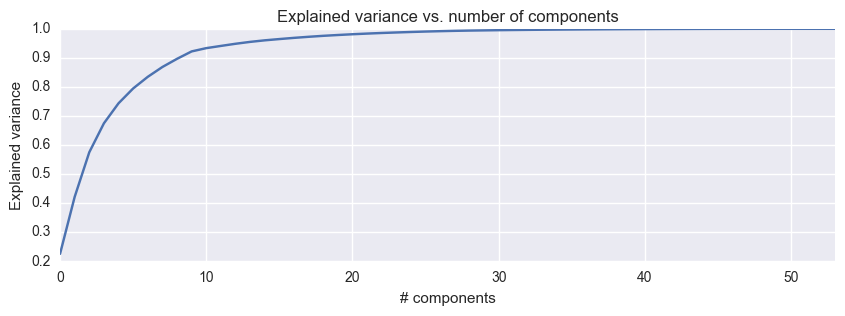

In [98]:
pca = PCA()
pca_fit = pca.fit(array_reduction)
reduced = pca.fit_transform(array_reduction)

ax = pd.Series(pca_fit.explained_variance_ratio_.cumsum()).plot(kind = 'line', figsize = (10,3));
_ = ax.set(xlabel = '# components', ylabel = 'Explained variance',
      title = 'Explained variance vs. number of components');

In [99]:
num_comp = 10
pca2 = PCA(n_components = num_comp)
pca2_fit = pca2.fit(array_reduction)

print('{:.2%}'.format(pca2_fit.explained_variance_ratio_.cumsum()[-1]) + ' of the variance is explained by the first ' + str(num_comp) + ' components')

92.23% of the variance is explained by the first 10 components


We can see that we can reduce our data down to 10 components. 

**Caveat:** From a brief Google search, it does not seem like PCA is recommended for categorical data or a mix of categorical and quantitative data. Linear discriminant analysis or multiple correspondance analysis were suggested as potential alternatives. But at the very least, we know we can reduce the number of features in our model to a subset of our original features, and we can identify the features underlying the principal components and test whether these features can help predict forest cover.

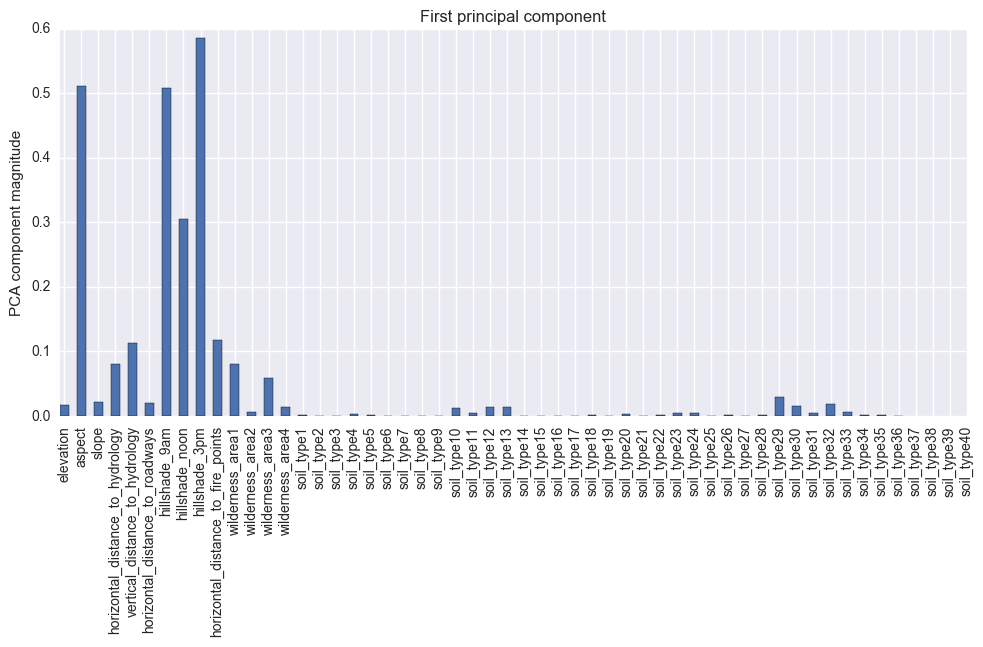

In [108]:
fig = plt.figure()
fig.set_size_inches(11.7, 5);
first_comp = abs(pca2_fit.components_[0])
ax = plt.bar(range(50), first_comp[0:50], 0.5)
_ = plt.xticks(np.arange(54) + 0.25, df_reduction.columns, rotation = 'vertical')
_ = plt.ylabel('PCA component magnitude')
_ = plt.title('First principal component')

From the plot of the first principal component, we note that **hillshade** and **aspect** (features relating to how much sunlight is received) make up most of the first principal component. These were features that were difficult to identify from simple pairwise comparisons, highlighting the importance of examining the entire feature space. 

Again, however, we must keep certain caveats in mind, namely: 1) we do know there is a fair amount of nonlinearity in the data, which PCA may not capture (a nonlinear kernel may help), and 2) the categorical data are likely not well represented. For example, it is unclear whether their individual component magnitudes should be summed to determine the contribution of these categories; as already mentioned, other methods may be superior.

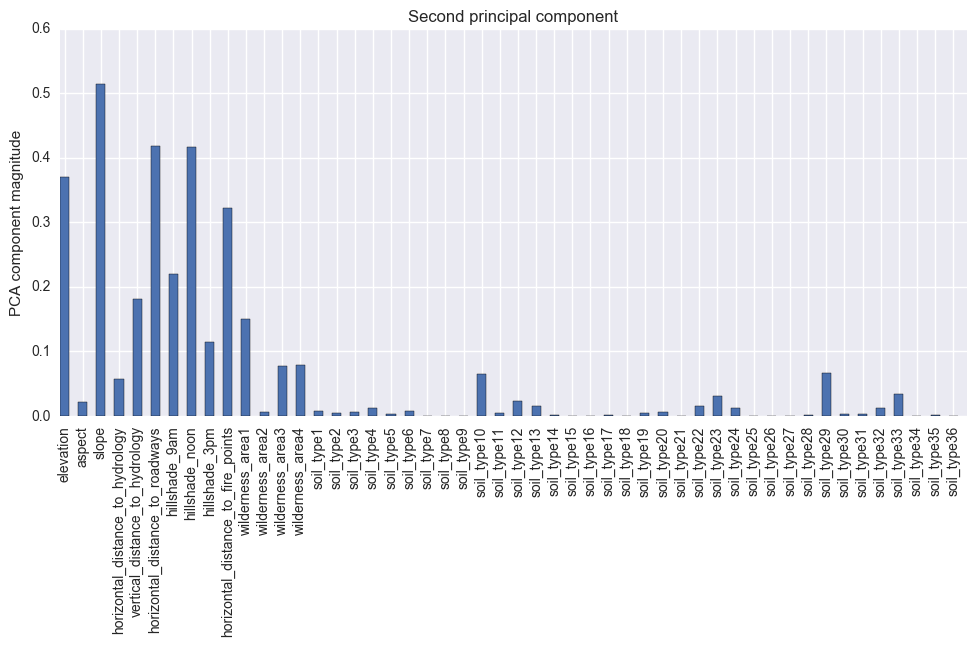

In [107]:
fig = plt.figure()
fig.set_size_inches(11.7, 5);
second_comp = abs(pca2_fit.components_[1])
ax = plt.bar(range(50), second_comp[0:50], 0.5)
_ = plt.xticks(np.arange(50) + 0.25, df_reduction.columns, rotation = 'vertical')
_ = plt.ylabel('PCA component magnitude')
_ = plt.title('Second principal component')

The second principal component is slightly more complicated, but, in addition to hillshade, **slope** of the hill, **distance to roadways**, **elevation** and **distance to fire points** all seem to contribute. Overall, our PCA has identified features related to hill shape as important ones to include in a classifier. It looks like wilderness area, if summed across the four areas, also has an important contribution.

## t-SNE 

Unlike PCA, t-SNE can handle complex relationships beyond simple linear ones. Furthermore, if t-SNE can identify clusters in our data, we can try and match features to those clusters, similar to how features underlying principal components are identified.

In [61]:
model = TSNE() #default is the faster Barnes-Hut method
tsne_fit = model.fit_transform(array_reduction)

**Note:** In reality t-SNE needs to be run multiple times to tune its hyperparameters and to find the clustering with the lowest error.

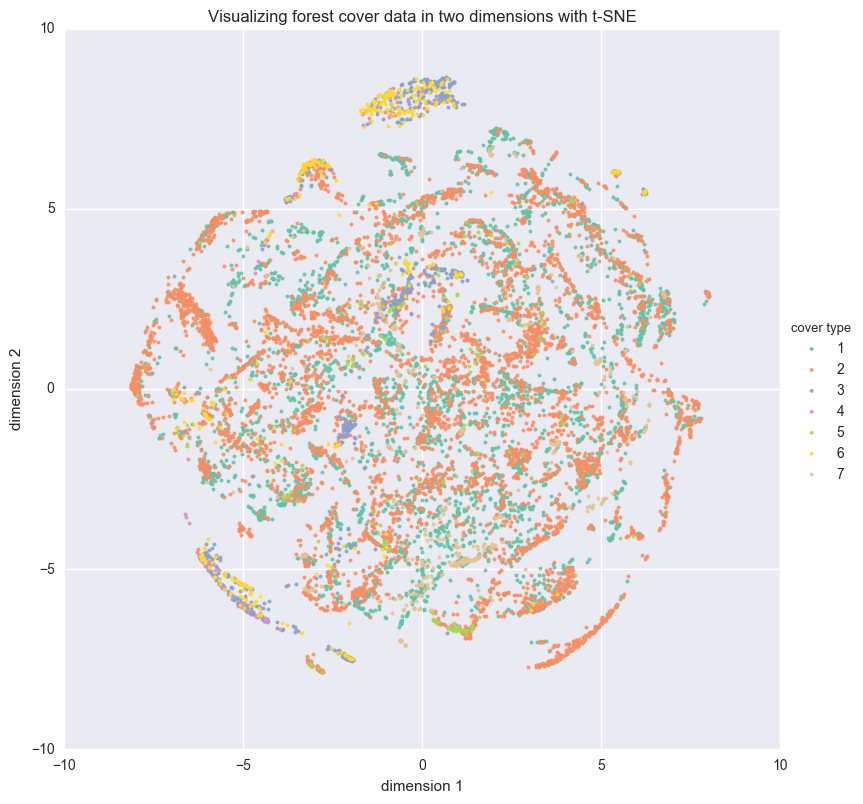

In [64]:
tsne_df = pd.DataFrame(tsne_fit, columns = ['dimension 1', 'dimension 2'], index = data_subset.index)
tsne_df['cover type'] = data_subset['cover_type']
ax = sns.lmplot('dimension 1', 'dimension 2', tsne_df, hue = 'cover type', palette = 'Set2', fit_reg=False, 
               size = 8,scatter_kws={'alpha':0.9,'s':8})
_ = ax.set(title = 'Visualizing forest cover data in two dimensions with t-SNE', ylim = (-10, 10))

We can see some potential clusters in the data. In particular, we see that cover types 3, 4 and 6 tend to cluster together. Cover types 1 and 2 also tend to overlap, consistent with what we noted earlier. More rigorous runs could be performed to try and identify greater structure in the data.